# Topic Modelling with Python

My emphasis is on the approach we follow in toping modelling. It totally depends on the requirement and here for my requirement below steps work well and gving good result on unseen data. 

**Process Followed**
 1. Start with a corpus of articles
 2. Identify underlying themes
 3. Assign themes to new articles
 
 
 
**Main Python Libraries Used**
 1. nltk
 2. BeautifulSoup
 3. gensim
 4. SnowballStemmer
 5. TfidfVectorizer
 6. KMeans
 7. KNeighborsClassifier
 8. plotly

In [1]:
## Import set of libraries which will help in our analysis

In [2]:
# Data handling libraries
import pandas as pd
import numpy as np
import re
from itertools import chain

# Background image handling
import base64
import codecs
from scipy.misc import imread

In [3]:
# Plot related libraries
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
from matplotlib import pyplot as plt
%matplotlib inline
from wordcloud import WordCloud

In [4]:
# Web scraping libraries
import urllib.request
from bs4 import BeautifulSoup

In [5]:
# NLP libraries
import nltk

import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
from gensim import corpora, models

# import set of stopwords and punctuations
from nltk.corpus import stopwords
from string import punctuation
from string import ascii_lowercase
from heapq import nlargest

# import set of NLP libraries
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Machine leaning algorithms
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

**1. Start with a corpus of articles**

a. Web Scraping 
 - I've used DoxyDonkey blog post as a source of articles (http://doxydonkey.blogspot.in). It has lots of short tech articles from various sources. 
 - Used BeautifulSoup library which is a wonderful library for web scraping. 
 - Pull all the urls of all pages present in the blogpost with iterating <'a href'> tag and text having "Older Posts"
 - Store all urls in a list variable i.e. links [ ]. 
 

In [6]:
# Pull all URLs from doxydonkey blogs
def getAllDoxyDonkeyPosts(url,links):
    with urllib.request.urlopen(url) as url:
        page = url.read().decode('utf8','ignore')
        
    soup = BeautifulSoup(page, "lxml")
    for a in soup.findAll('a'):
        try:
            url = a['href']
            title = a['title']
            if title == "Older Posts":
                print(title, url)
                links.append(url)
                getAllDoxyDonkeyPosts(url,links)
        except:
            title = ""
    return

blogUrl = "http://doxydonkey.blogspot.in"
links = []
getAllDoxyDonkeyPosts(blogUrl,links)

Older Posts http://doxydonkey.blogspot.in/search?updated-max=2017-05-23T19:53:00-07:00&max-results=7
Older Posts http://doxydonkey.blogspot.in/search?updated-max=2017-05-14T19:02:00-07:00&max-results=7&start=7&by-date=false
Older Posts http://doxydonkey.blogspot.in/search?updated-max=2017-05-02T19:43:00-07:00&max-results=7&start=14&by-date=false
Older Posts http://doxydonkey.blogspot.in/search?updated-max=2017-04-17T19:26:00-07:00&max-results=7&start=21&by-date=false
Older Posts http://doxydonkey.blogspot.in/search?updated-max=2017-04-10T18:56:00-07:00&max-results=7&start=28&by-date=false
Older Posts http://doxydonkey.blogspot.in/search?updated-max=2017-03-30T19:57:00-07:00&max-results=7&start=35&by-date=false
Older Posts http://doxydonkey.blogspot.in/search?updated-max=2017-03-20T19:47:00-07:00&max-results=7&start=42&by-date=false
Older Posts http://doxydonkey.blogspot.in/search?updated-max=2017-03-02T17:42:00-08:00&max-results=7&start=49&by-date=false
Older Posts http://doxydonkey.bl


b. Define Helper Functions

In [7]:
# Function to remove non-ascii charecters from corpus
def removeNonAscii(text):
    # re.sub(r'[^\x00-\x7F]+',' ', text)
    return ''.join([i if ord(i) < 128 else ' ' for i in text])

# Function to remove digits from corpus
def removeDigits(text):
    return re.sub(r'\d+', ' ', text)

c. Helper function to pull all articles present <'li'> tags. You can check it with Inspect Element of web page.

In [8]:
# Function to pull all articles from doxydonkey blogs
def getDoxyDonkeyText(testUrl):
    with urllib.request.urlopen(testUrl) as url:
        page = url.read().decode('utf8','ignore')
        
    soup = BeautifulSoup(page, "lxml")
    mydivs = soup.findAll("div", {"class":'post-body'})
    
    posts =[]
    for div in mydivs:
        posts+=map(lambda p:removeNonAscii(p.text), div.findAll("li"))
        #posts+=map(lambda p:p.text.encode('ascii', errors='replace').replace("?"," "), div.findAll("li"))
    return posts

d. Define and store articles in a list variable i.e. doxyDonkeyPosts [ ]

In [9]:
# Pull all articles 
doxyDonkeyPosts = []
for link in links:
    doxyDonkeyPosts+=getDoxyDonkeyText(link)

In [ ]:
# doxyDonkeyPosts

e. Define a list of custom stop words faced during the analysis. Actaully we don't need these words in analysis as these are not giving any meanning to the conext.  

In [10]:
# stopwords in english using NLTK and punctuation symbol from the Python string module
# order doesn't matter so store in set not list
my_list = ["'s", "'t", "n't", "'ll", "'re", "'ve", "'m", 
           "wo", "Mr.", "mr.", "Mr", "mr", "Mrs.", "mrs.", "Mrs", "mrs", 
           "million","billion","year","millions","billions","y/y",
           "''","``", "",  "--", "...", "..", " ", " . ", "," 
           "also", "said", "like",
           "company", "co", "le"]

customStopWords = set(stopwords.words('english')+list(punctuation)+list(ascii_lowercase)+my_list)

In [ ]:
# tokenize_and_stem(doxyDonkeyPosts)

f. Define different helper function for tokenizing and stemming texts. We will use these whenever it is required.

In [11]:
# I use both these functions to create a dictionary which becomes important in case I want to use stems for an algorithm, 
# but later convert stems back to their full words for presentation purposes. Guess what, I do want to do that!

# Here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

tokenizer = RegexpTokenizer(r'\w+')
stemmer = nltk.stem.SnowballStemmer("english")

# Tokenize and stem words present in article
def tokenizeAndStem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [removeDigits(word.lower()) for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    
    stems_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    stopped_tokens = [stemmer.stem(t) for t in tokens if not t in customStopWords]
    stems_tokens.append(stopped_tokens)
    return stems_tokens

# Tokenize words present in article
def tokenizeOnly(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [removeDigits(word.lower()) for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    # [tokenizer.tokenize(removeDigits(d.lower())) for d in text]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    
    stopped_tokens = [t for t in tokens if not t in customStopWords]
    filtered_tokens.append(stopped_tokens)
    return filtered_tokens

# Tokenize and stem words from list of articles 
def tokenizeAndStemArticles(text):
    # tokenizer = RegexpTokenizer(r'\w+')
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [tokenizer.tokenize(removeDigits(d.lower())) for d in doxyDonkeyPosts]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token_l in tokens:
        stopped_tokens = [t for t in token_l if not t in customStopWords]
        filtered_tokens.append(stopped_tokens)
    stems = [stemmer.stem(word) for t in filtered_tokens for word in t]
    return stems

In [ ]:
# example_words = ["I am accounting the account of India", "India accountability is under run."]
# tokenizeAndStem(example_words[1])

g. Below I use my stemming/tokenizing and tokenizing functions to iterate over the list of articles to create two vocabularies: one stemmed and one only tokenized. 

In [12]:
# Tokenized and ttemmed list of words
wordsStemmed = []

# Tokenized list of words
wordsTokenized = []

for i in doxyDonkeyPosts:
    allwords_stemmed = tokenizeAndStem(i) #for each item in 'doxyDonkeyPosts', tokenize/stem
    wordsStemmed.extend(allwords_stemmed) #extend the 'wordsStemmed' list
    
    allwords_tokenized = tokenizeOnly(i)
    wordsTokenized.extend(allwords_tokenized)

h. Using these two lists, I create a pandas DataFrame with the stemmed vocabulary as the index and the tokenized words as the column. The benefit of this is it provides an efficient way to look up a stem and return a full token.

In [13]:

pd_wordsWOStopwords = pd.DataFrame({'words': list(chain.from_iterable(wordsTokenized))}, 
                                   index = list(chain.from_iterable(wordsStemmed)))
print('There are ' + str(pd_wordsWOStopwords.shape[0]) + ' items in pd_wordsWOStopwords data frame')

There are 396110 items in pd_wordsWOStopwords data frame


In [14]:
pd_wordsWOStopwords.head(10)

,words
softbank,softbank
tech,tech
fund,fund
rankl,rankles
vcs,vcs
valuat,valuations
soar,soar
month,months
sinc,since
softbank,softbank


In [ ]:
# lemm = WordNetLemmatizer()

# texts = []
# for token_l in tokens:
#     stopped_tokens = [t for t in token_l if not t in customStopWords]
#     lemmed_texts = [lemm.lemmatize(w) for w in stopped_tokens]
#     texts.append(lemmed_texts)
# # print(texts)

i. Bolow are some plots to understand the data. I've Bar graph and Word Cloud view to show the gist of words available in corpus.

In [15]:
tokenizer = RegexpTokenizer(r'\w+')
allWords = [tokenizer.tokenize(d.lower()) for d in doxyDonkeyPosts]

allWords = list(chain.from_iterable(allWords))
# allWords

In [16]:
word_dist = nltk.FreqDist(allWords)
result = pd.DataFrame(word_dist.most_common(50), columns=['Word', 'Frequency']) # .set_index('Word')

data = [go.Bar(
            x = result.loc[:,'Word'].values,
            y = result.loc[:,'Frequency'].values,
            marker= dict(colorscale='Jet',
                         color = result.loc[:,'Frequency'].values
                        ),
            text='Text entries'
    )]

layout = go.Layout(
    title='Top 50 Words from Corpus'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

In [17]:
wordsWOStopwords = list(chain.from_iterable(wordsTokenized))

word_dist = nltk.FreqDist(wordsWOStopwords)
result = pd.DataFrame(word_dist.most_common(50), columns=['Word', 'Frequency']) # .set_index('Word')
# print(result)

data = [go.Bar(
            x = result.loc[:,'Word'].values,
            y = result.loc[:,'Frequency'].values,
            marker= dict(colorscale='Jet',
                         color = result.loc[:,'Frequency'].values
                        ),
            text='Text entries'
    )]

layout = go.Layout(
    title='Top 50 Words After Cleaning'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

In [18]:
with open("../DoxyDonkey Topic Modelling/image/batman.png", "rb") as image_file:
    encoded_string = base64.b64encode(image_file.read())    

# Generate the Mask
f1 = open("batman.png", "wb")
f1.write(codecs.decode(encoded_string,'base64'))
f1.close()
cloudMask = imread("batman.png")

(-0.5, 1586.5, 906.5, -0.5)

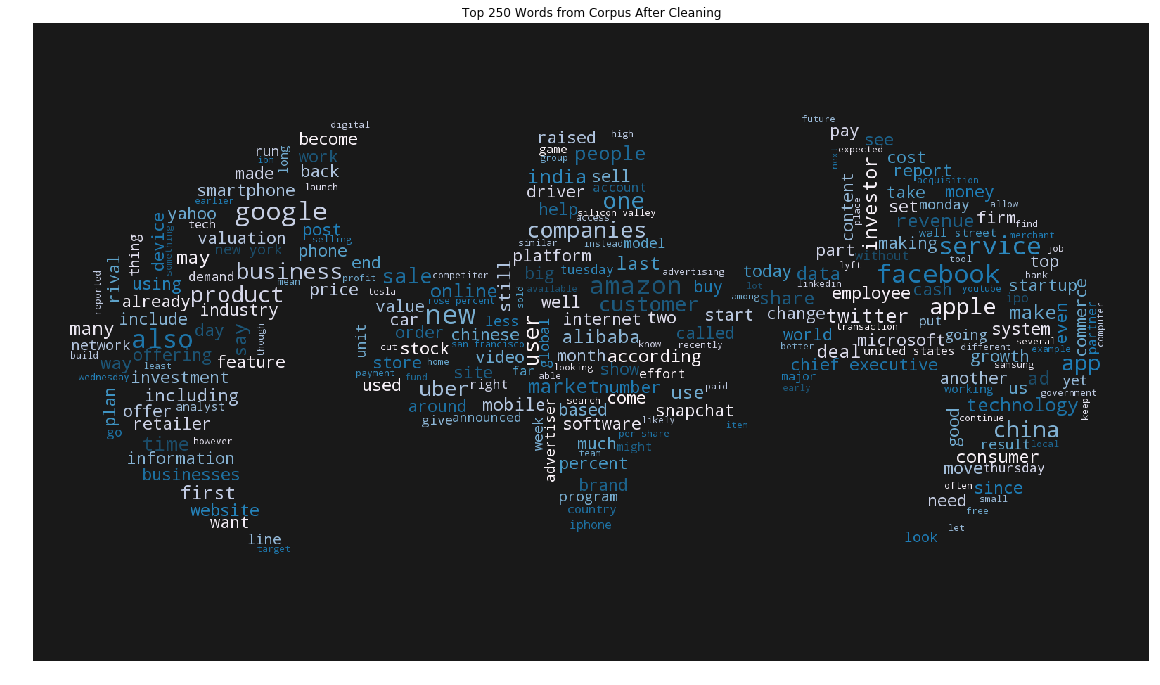

In [19]:
plt.figure(figsize=(20,18))
# The wordcloud of top 100 words from corpus 
wc = WordCloud(background_color="black", max_words=250, 
               mask=cloudMask, max_font_size= 40)
wc.generate(", ".join(wordsWOStopwords))
plt.title("Top 250 Words from Corpus After Cleaning")
plt.imshow(wc.recolor( colormap= 'PuBu' , random_state=17), alpha=0.9)
plt.axis('off')

**2. Identify underlying themes**

Here I've followed two approaches to identify underlying themes in articles. First is with Latent Dirichlet Allocation (LDA) and second with K-means clustering. 


a. Latent Dirichlet Allocation (LDA) approach

In [20]:
# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(wordsTokenized)

# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(text) for text in wordsTokenized]

In [21]:
# generate LDA model
ldamodel = models.ldamodel.LdaModel(corpus, num_topics=3, id2word = dictionary, passes=100)

In [78]:
print(ldamodel.print_topics(num_topics=3, num_words=20))

[(0, '0.007*"uber" + 0.006*"companies" + 0.005*"new" + 0.005*"google" + 0.004*"investors" + 0.004*"one" + 0.004*"also" + 0.004*"india" + 0.004*"round" + 0.004*"last" + 0.004*"data" + 0.004*"technology" + 0.004*"capital" + 0.004*"funding" + 0.003*"business" + 0.003*"raised" + 0.003*"would" + 0.003*"software" + 0.003*"people" + 0.003*"firm"'), (1, '0.017*"percent" + 0.009*"revenue" + 0.009*"china" + 0.008*"apple" + 0.007*"alibaba" + 0.006*"quarter" + 0.006*"sales" + 0.006*"market" + 0.006*"shares" + 0.005*"last" + 0.005*"new" + 0.005*"growth" + 0.005*"business" + 0.004*"according" + 0.004*"chinese" + 0.004*"share" + 0.004*"also" + 0.004*"stock" + 0.003*"first" + 0.003*"would"'), (2, '0.011*"facebook" + 0.009*"users" + 0.008*"amazon" + 0.007*"app" + 0.007*"google" + 0.006*"new" + 0.006*"mobile" + 0.006*"twitter" + 0.005*"service" + 0.005*"people" + 0.005*"ads" + 0.005*"also" + 0.004*"online" + 0.004*"video" + 0.004*"one" + 0.003*"apps" + 0.003*"ad" + 0.003*"data" + 0.003*"use" + 0.003*"ap

In [79]:
# # identify bigrams
# from nltk.collocations import *
# bigram_measures = nltk.collocations.BigramAssocMeasures()

# # construct bigram from a list of words
# finder = BigramCollocationFinder.from_words(wordsWOStopwords)
# sorted(finder.ngram_fd.items())

In [80]:
# count_vectorizer = CountVectorizer(stop_words=customStopWords)
# sentence_transform = count_vectorizer.fit_transform(wordsWOStopwords)

# print("The features are:\n {}".format(count_vectorizer.get_feature_names()))
# print("\nThe vectorized array looks like:\n {}".format(sentence_transform.toarray()))
# print("_"*90)
# print("Length of original list: {0} words\n"
#       "Length of list after stopwords removal: {1} words"
#       .format(len(doxyDonkeyPosts[0]), len(count_vectorizer.get_feature_names())))

In [81]:
# print(count_vectorizer.inverse_transform(sentence_transform))
# print(sentence_transform[0])

In [82]:
# define vectorizer parameters
# tfidfVectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
#                                  min_df=0.2, stop_words=customStopWords,
#                                  use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

# # Taking max_df and min_df to deault to remove prunning error 
# tfidfVectorizer = TfidfVectorizer(stop_words=customStopWords, use_idf=True, 
#                                   tokenizer=tokenizeAndStemArticles, ngram_range=(1,2))

b. K-means clustering approach

In [83]:
tfidfVectorizer = TfidfVectorizer(max_df=0.8,min_df=2,stop_words=customStopWords)

In [84]:
X=''
X = tfidfVectorizer.fit_transform(doxyDonkeyPosts)
X

<2804x13357 sparse matrix of type '<class 'numpy.float64'>'
	with 301082 stored elements in Compressed Sparse Row format>

In [85]:
X[0]

<1x13357 sparse matrix of type '<class 'numpy.float64'>'
	with 116 stored elements in Compressed Sparse Row format>

In [86]:
km = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 100, n_init = 1, verbose = True)

In [87]:
km.fit(X)

Initialization complete
Iteration  0, inertia 5202.252
Iteration  1, inertia 2678.905
Iteration  2, inertia 2672.776
Iteration  3, inertia 2671.008
Iteration  4, inertia 2670.297
Iteration  5, inertia 2669.933
Iteration  6, inertia 2669.700
Iteration  7, inertia 2669.621
Iteration  8, inertia 2669.576
Iteration  9, inertia 2669.544
Iteration 10, inertia 2669.508
Iteration 11, inertia 2669.490
Iteration 12, inertia 2669.488
Iteration 13, inertia 2669.487
Iteration 14, inertia 2669.483
Iteration 15, inertia 2669.471
Iteration 16, inertia 2669.457
Iteration 17, inertia 2669.452
Iteration 18, inertia 2669.447
Converged at iteration 18: center shift 0.000000e+00 within tolerance 7.232089e-09


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=3, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=True)

In [88]:
np.unique(km.labels_, return_counts=True)

(array([0, 1, 2]), array([ 372, 1071, 1361], dtype=int64))

In [89]:
text={}
for i,cluster in enumerate(km.labels_):
    oneDocument = doxyDonkeyPosts[i]
    if cluster not in text.keys():
        text[cluster] = oneDocument
    else:
        text[cluster] += oneDocument

In [90]:
keywords = {}
counts={}
for cluster in range(3):
    word_sent = nltk.word_tokenize(text[cluster].lower())
    word_sent=[word for word in word_sent if word not in customStopWords]
    freq = nltk.FreqDist(word_sent)
    keywords[cluster] = nlargest(100, freq, key=freq.get)
    counts[cluster]=freq

In [91]:
unique_keys = {}
for cluster in range(3):
    other_clusters=list(set(range(3))-set([cluster]))
    keys_other_clusters=set(keywords[other_clusters[0]]).union(set(keywords[other_clusters[1]]))
    print(other_clusters)
    print(set(keywords[other_clusters[0]]).union(set(keywords[other_clusters[1]])))

[1, 2]
{'global', 'online', 'google', 'still', 'car', 'advertisers', 'way', 'made', 'internet', 'products', 'product', 'cloud', 'e-commerce', 'plans', 'biggest', 'inc.', 'companies', 'india', 'funding', 'tesla', 'today', '1', 'data', 'information', 'last', 'financial', 'users', 'social', 'value', 'facebook', 'network', 'government', 'valuation', 'web', 'revenue', 'user', 'group', 'month', 'chief', 'instagram', 'private', 'around', 'market', 'offering', 'time', 'money', 'amazon', 'may', 'messaging', 'ad', 'two', 'public', 'app', 'technology', 'years', 'digital', 'business', 'customer', 'consumers', 'chinese', 'snapchat', 'sales', 'videos', 'microsoft', 'percent', 'including', 'called', 'mobile', 'video', 'work', 'search', 'one', 'feature', 'media', 'deal', 'china', 'apps', 'apple', 'store', 'industry', 'investment', 'price', 'lyft', 'cash', 'customers', 'big', 'using', 'round', 'drivers', 'platform', 'alibaba', 'even', 'ads', 'brands', 'share', 'cars', 'capital', 'would', 'uber', 'devic

In [92]:
unique_keys = {}
for cluster in range(3):
    other_clusters=list(set(range(3))-set([cluster]))
    keys_other_clusters=set(keywords[other_clusters[0]]).union(set(keywords[other_clusters[1]]))
    unique=set(keywords[cluster])-keys_other_clusters
    unique_keys[cluster]=nlargest(10, unique, key=counts[cluster].get)

In [93]:
unique_keys

{0: ['quarter',
  'profit',
  'rose',
  'earnings',
  'analysts',
  'cents',
  'net',
  'per',
  'fell',
  'reported'],
 1: ['ads',
  'video',
  'search',
  'ad',
  'product',
  'apps',
  'social',
  'way',
  'buy',
  'web'],
 2: ['uber',
  'india',
  'chinese',
  'round',
  'capital',
  'money',
  'public',
  'deal',
  'firm',
  'raised']}

**3. Assign themes to new articles**

Taken a random article and checking whether it is lying in the right cluster or not.

As you can see below article is related to social networking and it should come under that theme only. I've used KNN classification algorithm to find out right theme of article.

In [94]:
article = "Facebook Inc. has been giving advertisers an inflated metric for the average time users spent watching a video, a measurement that may have helped boost marketer spending on one of Facebook’s most popular ad products. The company, owner of the world’s largest social network, only counts a video as viewed if it has been seen for more than 3 seconds. The metric it gave advertisers for their average video view time incorporated only the people who had watched the video long enough to count as a view in the first place, inflating the metric because it didn’t count anyone who didn’t watch, or watched for a shorter time. Facebook’s stock fell more than 1.5 percent in extended trading after the miscalculation was earlier reported in the Wall Street Journal. Facebook had disclosed the mistake in a posting on its advertiser help center web page several weeks ago. Big advertising buyers and marketers are upset about the inflated metric, and asked the company for more details, according to the report in the Journal, citing unidentified people familiar with the situation. The Menlo Park, California-based company has kept revenue surging in part because of enthusiasm for its video ads, which advertisers compare in performance to those on Twitter, YouTube and around the web."

In [95]:
classifier = KNeighborsClassifier(n_neighbors=3)
classifier.fit(X,km.labels_)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [96]:
test=tfidfVectorizer.transform([article])

In [97]:
test

<1x13357 sparse matrix of type '<class 'numpy.float64'>'
	with 94 stored elements in Compressed Sparse Row format>

In [98]:
classifier.predict(test)

array([2])